# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [1]:
import time
import itertools
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import Mag
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [2]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, J, gx, gz=0): # gx is transverse field, gz the longitudinal
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

### Load VQE parameters

In [3]:
def sort_vals(vals):
    """ vals is (unsorted) dictionary of parameters from VQE ansatz circuit, this returns sorted values as list """
    indices = np.array([_.index for _ in vals])           # unordered list of indices from the ParameterVectorElement(Theta(INDEX))
    vals_sorted = np.array([vals[_] for _ in vals])       # unordered list of values (but same ordering as indices)
    return vals_sorted[np.argsort(indices)]

def init_vqe(vals, L):
    #return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(sort_vals(vals))
    return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(vals)

In [4]:
L = 5
anti = -1
#filename = f'data/params_VQE_Ising_L{L}_anti_{anti}.npz'   # name of the data file that is used
filename = f'data/params_VQE_Ising_L{L}_anti_{anti}_50x50.npz'

VQE_vals = np.load(filename, allow_pickle=True)
gxs = VQE_vals['gx_list']
gzs = VQE_vals['gz_list']
phis = VQE_vals['opt_params']
N = int(np.sqrt(gxs.size))
gxs = np.logspace(-2, 2, N)#gxs.reshape(N,N)
gzs = np.logspace(-2, 2, N)#gzs.reshape(N,N)
phis = phis.reshape(N,N,-1) #(gx, gz)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [12]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 5 # system size
num_trash = 2
thetas = np.random.uniform(0, 2*np.pi, num_trash*L+num_trash) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [8]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    #if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.ry(thetas[2*L], 4)
    circ.ry(thetas[2*L+1], 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    return circ

# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit3(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state, L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

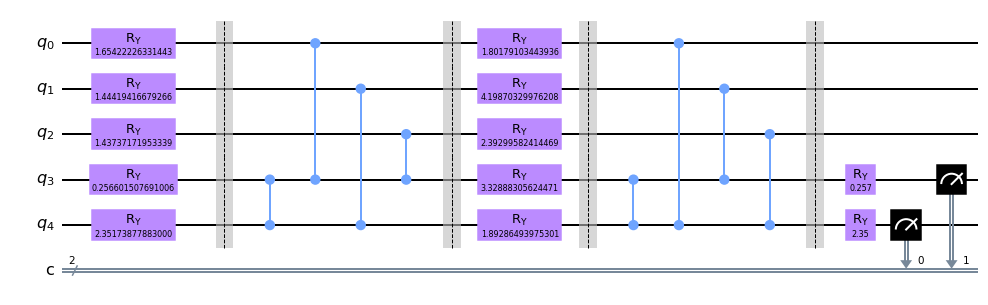

In [13]:
circ = prepare_circuit3(thetas,L,num_trash)
circ.draw('mpl')

In [14]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [16]:
idx = 30
J, gx, gz = -1., gxs[idx], gzs[idx]
phi = phis[idx, idx]

def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit3(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, memory=True)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, L, num_trash, phi)

{'00': 23, '11': 30, '10': 34, '01': 13}

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [17]:
#reset random seed
np.random.seed(123)

In [18]:
def hamming_distance(out):
    return sum(key.count('1') * value for key, value in out.items())   

def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0, model="bh"):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        if model=="ising": 
            J, gx, gz = p
            init_state, _ = ising_groundstate(L, J, gx, gz)
        elif model=="bh":
            init_state = p#init_states[p]
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = hamming_distance(out)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0):
    if thetas is None:
        n_params = (num_trash*L+num_trash)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    # optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    optimizer = SPSA(maxiter=max_iter,
                     #blocking=True,
                     callback=store_intermediate_result,
                     #learning_rate=1e-1,
                     #perturbation=0.4
                     ) # recommended from qiskit (first iteraction takes quite long)
                       # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

In [384]:
params = [(18,38)]
thetas_test, loss, accepted = optimize(params, L, max_iter=40)

Initial cost: 1.103
Time: 14.22470 sec
(array([-0.16285553,  3.65120694,  6.6532771 ,  5.61295898,  6.09735639,
        5.88073986,  2.6530239 ,  3.32631224,  1.26430439,  6.07280626,
        2.60443315,  5.7947276 ]), 0.018, 120)


In [210]:
params = [(-1.0, 0.1, 0.1)]
thetas_test, loss, accepted = optimize(params, 5, 2, max_iter=40, vqe=False)

Initial cost: 1.101
Time: 10.28256 sec
(array([-0.14844581,  2.77815889, -1.60475003,  3.16465567,  3.26435023,
        4.775246  ,  1.85663655,  5.82447654,  0.05813272,  6.12775264,
        4.08582567,  3.02215344]), 0.004, 120)


## Trying stuff out

### Train with two different states from each normal "fake phase"

In [293]:
params = [(18,32),(32,18)]
print(gxs[params[0][0]], gzs[params[0][1]])
thetas, loss, accepted = optimize(params, L, 1)
thetas_normal_phase = thetas

0.29470517025518095 4.094915062380423
Initial cost: 0.251
Time: 178.08235 sec
(array([4.78484235, 1.7394315 , 1.53692265, 4.81255879, 2.59541599,
       4.48628567]), 0.082, 1200)


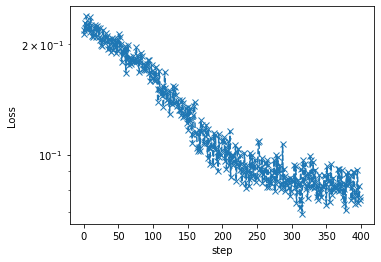

In [294]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [296]:
points = 50
J = -1.0
#x,y = gxs[::points], gzs[:points]
#x,y = np.meshgrid(x,y)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, L, 1, (i,j), shots=shots)
        init_state, _ = ising_groundstate(5, J, gx, gz)
        Smags[i,j] = np.real(init_state.T.conj()@Mag(5,-1)@init_state)

<ipython-input-297-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-297-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


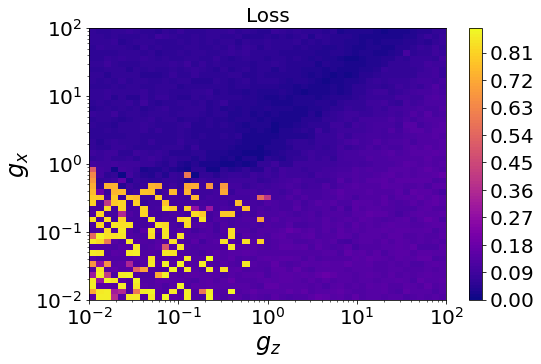

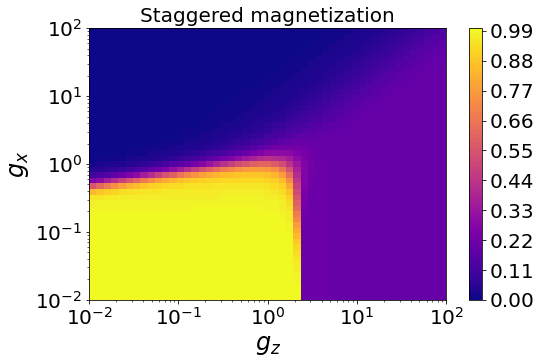

In [297]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-273-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-273-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


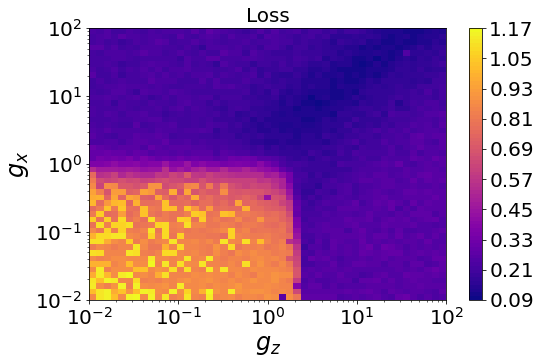

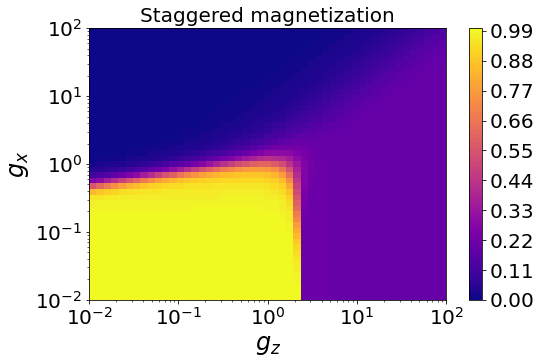

In [273]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-265-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-265-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


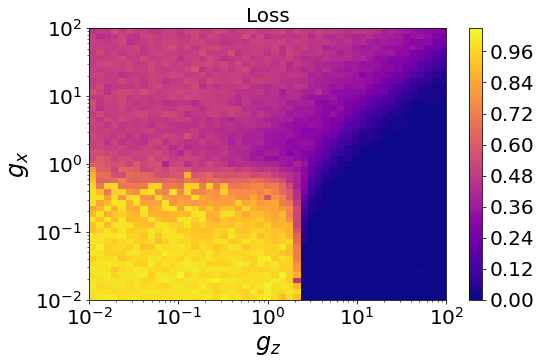

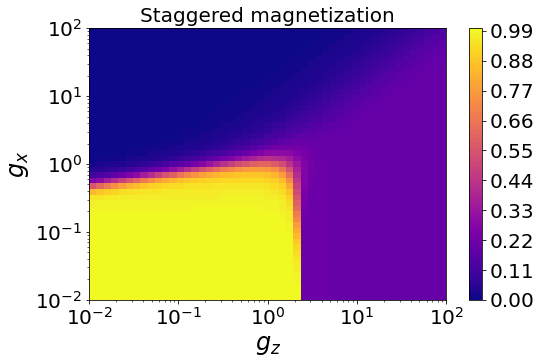

In [265]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [266]:
J = -1
gz = gzs[0]
cost1, Smags1, Smags12 = [], [], []
shots = 10000
Ll = 5
for i,gx in enumerate(gxs):
    cost1.append(cost_function_single(thetas, L, 2, (i, 0), shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags1.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    #init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    #Smags12.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
gx = gxs[0]
cost2, Smags2, Smags22 = [], [], []
for i,gz in enumerate(gzs):
    cost2.append(cost_function_single(thetas, L, 2, (0, i), shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags2.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    #init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    #Smags22.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))

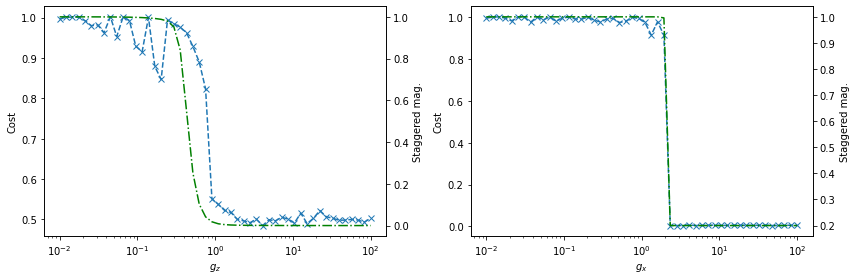

In [267]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
ax4 = ax3.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Cost")
ax1.plot(gzs, cost1, "x--")
ax2.plot(gzs, Smags1, "g-.")
#ax2.plot(gzs, Smags12, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Cost")
ax3.plot(gzs, cost2, "x--")
ax4.plot(gzs, Smags2, "g-.")
#ax4.plot(gzs, Smags22, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")
fig.tight_layout()

## Bose Hubbard

In [21]:
L = 20
N = 10
#filename = f'data/wf_BH_L{L}.npz'
filename = '../wf_BH_L20.npz'


VQE_vals = np.load(filename, allow_pickle=True)
deltas = VQE_vals['deltat_array']
Vs = VQE_vals['V_array']
init_states = VQE_vals['wf_array']
Vs = np.linspace(2,8,10)
deltas = np.linspace(-1,1,10)
init_states = init_states.reshape(N,N,-1) #(delta, V)

In [ ]:
print(deltas[0], Vs[0])
thetas, loss, accepted = optimize([init_states[-1,0]], L, 1, vqe=False)
thetas_bh = thetas

-1.0 2.0


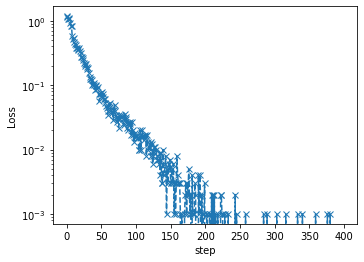

In [347]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [348]:
points = 10
x,y = np.meshgrid(deltas,Vs)
cost = np.zeros((points,points))
Smags = np.zeros((points,points))
shots = 1000
for i,d in enumerate(deltas):
    for j,v in enumerate(Vs):
        cost[i,j] = cost_function_single(thetas, L, 2, init_states[i,j], shots=shots, vqe=False)

<ipython-input-350-961bb0176d09>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


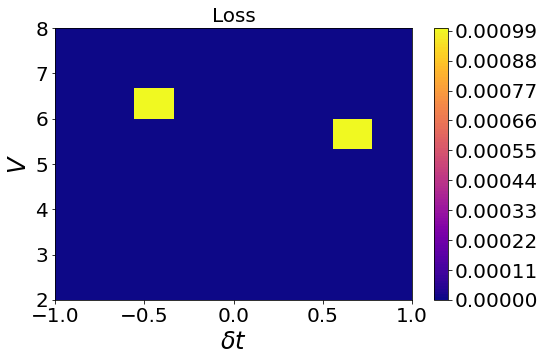

In [350]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
#plt.xscale("log")
#plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_ylabel(r"$V$",fontsize=24)
ax.set_xlabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)